In [1]:
import os
import io
import en_core_web_lg

import pandas as pd 
import tensorflow as tf 
import plotly.express as px
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split

nlp = en_core_web_lg.load()

In [2]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [3]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
display(100*df.isnull().sum()/df.shape[0])

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [5]:
# delete empty columns
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [6]:
# data cleaning with lemmatization
df["review_clean"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["review_clean"] = df["review_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["review_clean"] = df["review_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df["len_review"] = df["review_clean"].apply(lambda x: len(x))
# label encoding
label = LabelEncoder()
df['target'] = label.fit_transform(df['v1'])

In [7]:
display(100*df.isnull().sum()/df.shape[0])

v1              0.0
v2              0.0
review_clean    0.0
len_review      0.0
target          0.0
dtype: float64

<AxesSubplot: >

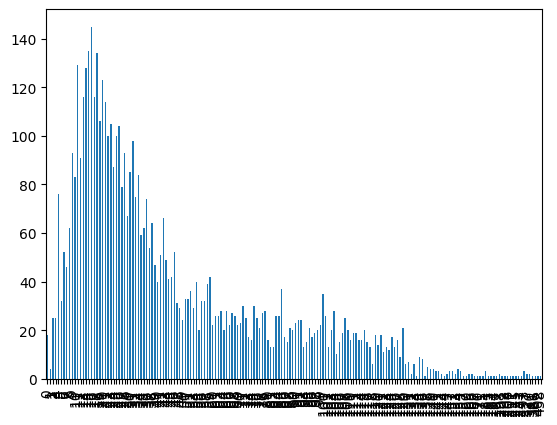

In [8]:
df['len_review'].value_counts().sort_index().plot(kind='bar')

In [9]:
# text-to-digital transformation for computer comprehension
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) 
tokenizer.fit_on_texts(df["review_clean"])
df["review_encoded"] = tokenizer.texts_to_sequences(df["review_clean"])

In [10]:
# addition of a pading to have an entry shape in the model which is identical
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(df["review_encoded"], padding="post")
# creation of test data and validation
xtrain, xval, ytrain, yval = train_test_split(reviews_pad,df["target"], test_size=0.3)

train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [11]:
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[ 73 156   0 ...   0   0   0]
 [147 191 183 ...   0   0   0]
 [635  58   0 ...   0   0   0]
 ...
 [727 376 174 ...   0   0   0]
 [112 275  19 ...   0   0   0]
 [185   5 278 ...   0   0   0]], shape=(64, 54), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0], shape=(64,), dtype=int32)


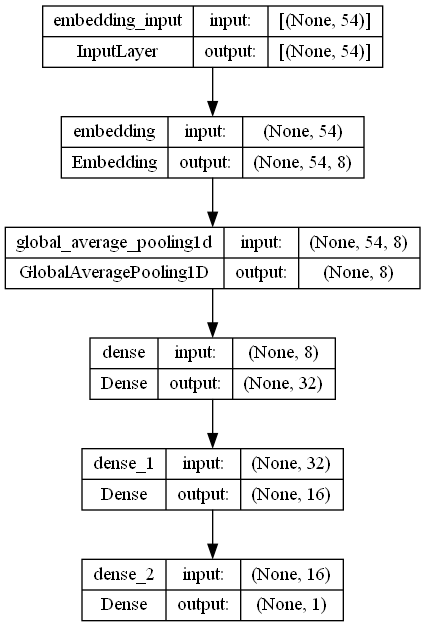

In [12]:
# creation of the model
vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([             
            tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),  
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.Dense(16, activation='relu'),      
            tf.keras.layers.Dense(1, activation="sigmoid")
                ])

tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
# determination of loss and accuracy calculation data
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [14]:
# visualization of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 8)             65528     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 66,361
Trainable params: 66,361
Non-trainable params: 0
____________________________________________________

In [ ]:
weights = 1/(df["target"]).value_counts()
weights = weights * len(df)/13
weights = {index: values for index,
            values in zip(weights.index, weights.values)}

In [ ]:
Checkpoint_create = tf.keras.callbacks.ModelCheckpoint(
                        filepath='model_weights.hdf5',
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        save_freq='epoch',
                        period=1)

In [15]:
# train model
model.fit(train_batch, 
            epochs=20, 
            validation_data=val_batch,
            class_weight=weights,
            callbacks=Checkpoint_create)

Epoch 1/20
61/61 [==============================] - 1s 4ms/step - loss: 0.6597 - accuracy: 0.8459 - val_loss: 0.6098 - val_accuracy: 0.8565
Epoch 2/20
61/61 [==============================] - 0s 3ms/step - loss: 0.5001 - accuracy: 0.8700 - val_loss: 0.4021 - val_accuracy: 0.8565
Epoch 3/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3610 - accuracy: 0.8700 - val_loss: 0.3776 - val_accuracy: 0.8565
Epoch 4/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3458 - accuracy: 0.8700 - val_loss: 0.3633 - val_accuracy: 0.8565
Epoch 5/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3297 - accuracy: 0.8700 - val_loss: 0.3404 - val_accuracy: 0.8565
Epoch 6/20
61/61 [==============================] - 0s 2ms/step - loss: 0.2955 - accuracy: 0.8700 - val_loss: 0.2882 - val_accuracy: 0.8571
Epoch 7/20
61/61 [==============================] - 0s 2ms/step - loss: 0.2222 - accuracy: 0.8938 - val_loss: 0.1857 - val_accuracy: 0.9336
Epoch 8/20
61/61 [==

In [16]:
# accuracy score and loss
history_model = pd.DataFrame(model.history.history)
history_model

,loss,accuracy,val_loss,val_accuracy
0,0.659691,0.845897,0.609791,0.856459
1,0.500069,0.870000,0.402085,0.856459
2,0.360953,0.870000,0.377568,0.856459
3,0.345844,0.870000,0.363260,0.856459
4,0.329668,0.870000,0.340418,0.856459
5,0.295538,0.870000,0.288222,0.857057
6,0.222185,0.893846,0.185689,0.933612
7,0.120396,0.964872,0.106983,0.973684
8,0.075246,0.978462,0.083739,0.974880
9,0.058635,0.983590,0.075592,0.976077


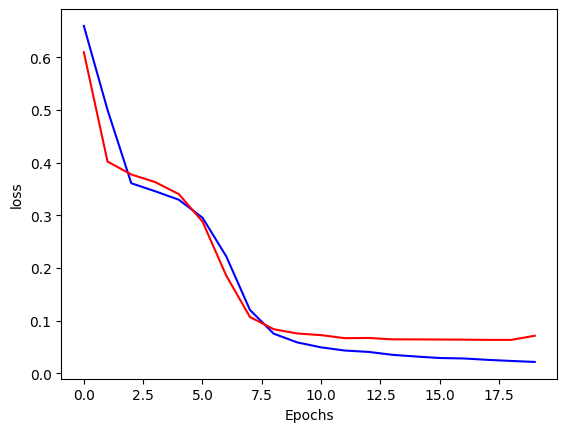

In [17]:
# visualization of the loss
plt.plot(history_model["loss"], color="b")
plt.plot(history_model["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

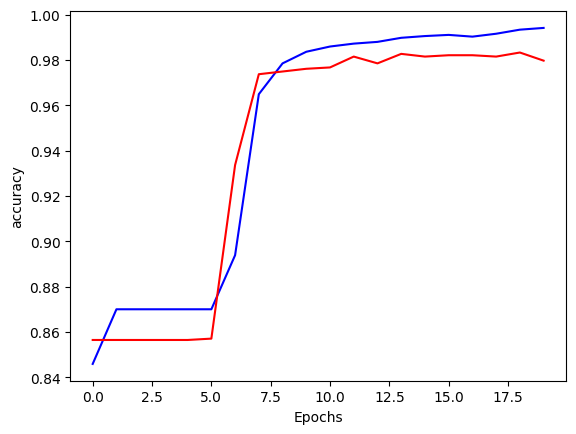

In [18]:
# visualization of accuracy
plt.plot(history_model["accuracy"], color="b")
plt.plot(history_model["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

## test on a model already usable download via tenserflow hub

In [19]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [20]:
label = LabelEncoder()
df['target'] = label.fit_transform(df['v1'])

In [21]:
xtrain, xval, ytrain, yval = train_test_split(df["v2"],df["target"], test_size=0.3)

train_data = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_data = tf.data.Dataset.from_tensor_slices((xval, yval))

In [22]:
# model embedding taken from tenserflow hub
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [31]:
model_hub = tf.keras.Sequential()
model_hub.add(hub_layer)
model_hub.add(tf.keras.layers.Dense(32, activation='selu'))
model.add(tf.keras.layers.Dropout(0.2))
model_hub.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model_hub.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_hub.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_9 (Dense)             (None, 32)                4128      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 124,647,361
Trainable params: 124,647,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
weights = 1/(df["target"]).value_counts()
weights = weights * len(df)/13
weights = {index: values for index,
            values in zip(weights.index, weights.values)}

In [ ]:
Checkpoint_create = tf.keras.callbacks.ModelCheckpoint(
                        filepath='model_hub_weights.hdf5',
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        save_freq='epoch',
                        period=1)

In [32]:
model_hub.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
# train model
model_hub.fit(train_data.shuffle(10000).batch(512),
                epochs=20,
                class_weight=weights,
                validation_data=val_data.batch(512),
                verbose=1,
                callbacks=Checkpoint_create
                )

Epoch 1/20


c:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 10s 1s/step - loss: 0.5481 - accuracy: 0.9018 - val_loss: 0.4180 - val_accuracy: 0.9593
Epoch 2/20
8/8 [==============================] - 9s 1s/step - loss: 0.2907 - accuracy: 0.9810 - val_loss: 0.2284 - val_accuracy: 0.9539
Epoch 3/20
8/8 [==============================] - 9s 1s/step - loss: 0.1343 - accuracy: 0.9805 - val_loss: 0.1531 - val_accuracy: 0.9587
Epoch 4/20
8/8 [==============================] - 9s 1s/step - loss: 0.0724 - accuracy: 0.9897 - val_loss: 0.1233 - val_accuracy: 0.9671
Epoch 5/20
8/8 [==============================] - 9s 1s/step - loss: 0.0436 - accuracy: 0.9962 - val_loss: 0.1058 - val_accuracy: 0.9725
Epoch 6/20
8/8 [==============================] - 9s 1s/step - loss: 0.0284 - accuracy: 0.9982 - val_loss: 0.0965 - val_accuracy: 0.9725
Epoch 7/20
8/8 [==============================] - 9s 1s/step - loss: 0.0200 - accuracy: 0.9997 - val_loss: 0.0916 - val_accuracy: 0.9731
Epoch 8/20
8/8 [==============================] - 9

In [34]:
history_model_hub = pd.DataFrame(model_hub.history.history)
history_model_hub

,loss,accuracy,val_loss,val_accuracy
0,0.548116,0.901795,0.418016,0.959330
1,0.290691,0.981026,0.228356,0.953947
2,0.134321,0.980513,0.153111,0.958732
3,0.072369,0.989744,0.123299,0.967105
4,0.043614,0.996154,0.105830,0.972488
5,0.028441,0.998205,0.096528,0.972488
6,0.019974,0.999744,0.091598,0.973086
7,0.014884,0.999744,0.089276,0.973684
8,0.011419,0.999744,0.088332,0.973684
9,0.009011,1.000000,0.088318,0.973684


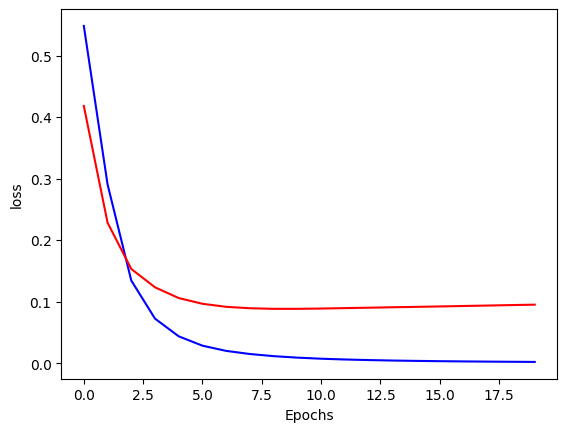

In [35]:
plt.plot(history_model_hub["loss"], color="b")
plt.plot(history_model_hub["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

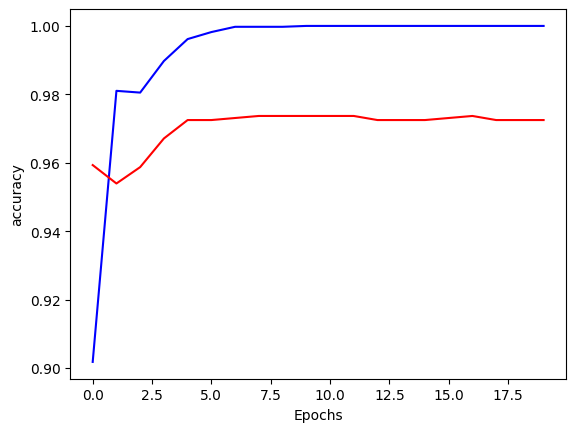

In [36]:
plt.plot(history_model_hub["accuracy"], color="b")
plt.plot(history_model_hub["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()